In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
results = pd.read_excel('../../results/experimental/cell-based-assays.xlsx', 'Sheet2', header=[0, 1, 2])
results = results.rename(dict(zip(results.columns, ['Chenodiol', 'Cysteamine-HCl', 'Arundine'])), axis=1)
results = results.set_index(('class', 'assay', 'concentration'))
results = results.drop(results.columns[0], axis=1)
results = results.transpose()
results = results.rename_axis(['class', 'assay', 'concentration'], axis='index')
results['conc'] = results.index.get_level_values('concentration')
results['class'] = pd.Categorical(results.index.get_level_values('class'))
new_class_names = [r'A$\beta$ induced toxicity', r'A$\beta$ clearance', r'A$\beta$ secretion', 'Tau phosphorylation', 'LPS neuroinflammation', 'Neurogenesis and neurite outgrowth', 'Trophic factor withdrawal', 'Tau aggregation']
mapper = dict(zip(results['class'].cat.categories, new_class_names))
results = results.drop('class', axis=1)
results = results.rename(mapper, axis=0, level=0)
results

('class', 'assay', 'concentration')                           Chenodiol (TUDCA)  \
class                     assay                concentration                      
A$\beta$ induced toxicity MTT (viability)      c1                           NaN   
                                               c2                           NaN   
                                               c3                           NaN   
A$\beta$ clearance        Abeta in SN          c4                           0.0   
                                               c5                           0.0   
...                                                                         ...   
Trophic factor withdrawal LDH (cell death)     c2                           0.0   
                                               c3                           0.0   
Tau aggregation           Tau aggregation ΔRFU c4                           NaN   
                                               c5                           NaN   
                                               c6                           NaN   

('class', 'assay', 'concentration')                           Cysteamine HCl (Cysteamine)  \
class                     assay                concentration                                
A$\beta$ induced toxicity MTT (viability)      c1                                     NaN   
                                               c2                                     NaN   
                                               c3                                     NaN   
A$\beta$ clearance        Abeta in SN          c4                                     0.0   
                                               c5                                     1.0   
...                                                                                   ...   
Trophic factor withdrawal LDH (cell death)     c2                                     0.0   
                                               c3                                     0.0   
Tau aggregation           Tau aggregation ΔRFU c4                                     NaN   
                                               c5                                     NaN   
                                               c6                                     NaN   

('class', 'assay', 'concentration')                           Arundine (3,3'-Diindolylmethane)  \
class                     assay                concentration                                     
A$\beta$ induced toxicity MTT (viability)      c1                                          NaN   
                                               c2                                          NaN   
                                               c3                                          NaN   
A$\beta$ clearance        Abeta in SN          c4                                          0.0   
                                               c5                                         -1.0   
...                                                                                        ...   
Trophic factor withdrawal LDH (cell death)     c2                                          0.0   
                                               c3                                          0.0   
Tau aggregation           Tau aggregation ΔRFU c4                                          NaN   
                                               c5                                          NaN   
                                               c6                                          NaN   

('class', 'assay', 'concentration')                          conc  
class                     assay                concentration       
A$\beta$ induced toxicity MTT (viability)      c1              c1  
                                               c2              c2  
                                               c3              c3  
A$\beta$ clearance        Abeta in SN          c4              c4  
                           

In [3]:
plt.rcParams['figure.facecolor'] = 'lightgray'

In [4]:
gb_class = results.groupby('class')
assays_per_class = {name: len(df) / 3 for name, df in gb_class}
assays_per_class

{'A$\\beta$ clearance': 3.0,
 'A$\\beta$ induced toxicity': 1.0,
 'A$\\beta$ secretion': 3.0,
 'LPS neuroinflammation': 6.0,
 'Neurogenesis and neurite outgrowth': 4.0,
 'Tau aggregation': 1.0,
 'Tau phosphorylation': 3.0,
 'Trophic factor withdrawal': 4.0}

[Text(0, 0, 'Chenodiol (TUDCA)'),
 Text(1, 0, 'Cysteamine HCl (Cysteamine)'),
 Text(2, 0, "Arundine (3,3'-Diindolylmethane)")]

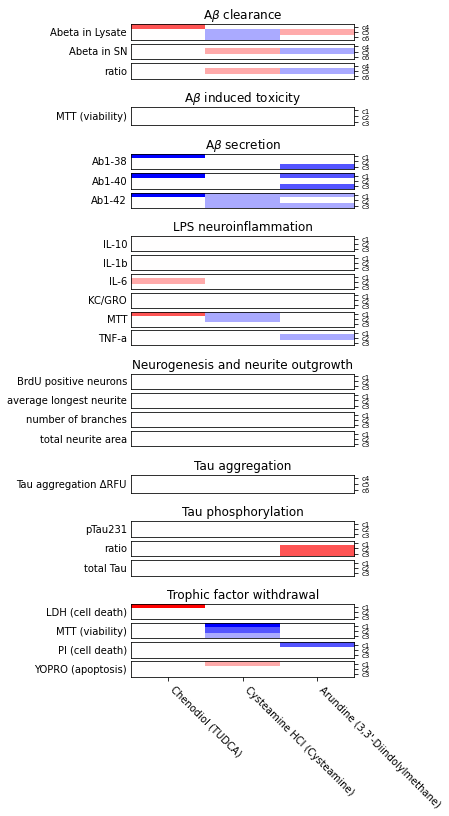

In [5]:
fig = plt.figure(figsize=(4, 12))
outer_grid = gridspec.GridSpec(len(gb_class), 1, height_ratios = list(assays_per_class.values()), figure=fig, hspace=0.5) 

def process_class(classname, classdata, i, fig):
    n_assays = int(len(classdata) / 3)
    first_assay_name = classdata.index.get_level_values('assay')[0]
    inner_gs = gridspec.GridSpecFromSubplotSpec(n_assays, 1, subplot_spec=outer_grid[i], hspace=0.25)
    gb_assay = classdata.groupby('assay')
    for j, zipitem in enumerate(zip(inner_gs, gb_assay)):
        cell, gbitem = zipitem
        ax = plt.subplot(cell)
        assay_name, assay_data = gbitem
        plot_assay(ax, assay_name, assay_data)
        if j == 0:
            ax.set_title(classname)
    return(ax)

def plot_assay(axi, assay_name, assay_data):
        axi.imshow(assay_data.iloc[:, range(3)], aspect='auto', interpolation='none', cmap='bwr', vmin=-3, vmax=3)
        axi.set_xticks(range(3))
        axi.set_yticks(range(assay_data.shape[0]))
        axi.set_yticklabels(assay_data.conc, fontsize=7)
        axi.set_ylabel(assay_name, rotation=0, verticalalignment='center', horizontalalignment='right')
        axi.tick_params(right=True, left=False, labelright=True, labelleft=False)
        axi.set_xticks([])
        #axi.set_xticklabels([])
        return(axi)


for i, classinfo in enumerate(gb_class):
    classname, classdata = classinfo
    axi = process_class(classname, classdata, i, fig)
axi.set_xticks(range(3))
axi.set_xticklabels(results.columns[:-1], rotation=-45, horizontalalignment='left')

In [6]:
%connect_info

{
  "shell_port": 57757,
  "iopub_port": 57758,
  "stdin_port": 57759,
  "control_port": 57761,
  "hb_port": 57760,
  "ip": "127.0.0.1",
  "key": "192b6eda-fcf68202299b329a540fc75a",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-da6a8744-3d2b-473c-90e7-75c28a21a897.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
